In [1]:
%matplotlib inline

Some ICA math
-------------------

We want to decompose our data $X \in \mathbb{R}^{C \times T}$

$$ X = As $$ 

where $A \in \mathbb{R}^{C \times C}$ is the mixing matrix and $s \in \mathbb{R}^{C \times T}$ are the (independant) latent sources

Each row of $s$ is a statistically independent time series and each column of $A$ is a spatial filter

ICA finds directions in the feature space
corresponding to projections with high non-Gaussianity. We thus obtain
a decomposition into independent components, and the artifact's contribution
is typically localized in only a small number of components.
These components have to be correctly identified and removed.

If EOG or ECG recordings are available, they can be used in ICA to
automatically select the corresponding artifact components from the
decomposition. To do so, you have to first build an `mne.Epochs` object
around blink or heartbeat events.

ICA is implemented in MNE using the `mne.preprocessing.ICA` class,
which we will review here.



First, let us load the data and filter it

In [2]:
import mne
from mne.datasets import sample

# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /local_mount/space/meghnn/1/users/mjas/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


1Hz high pass is often helpful for fitting ICA (already lowpassed @ 40 Hz)

In [3]:
raw.filter(1., None, n_jobs=1, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 497 samples (3.310 sec) selected


<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.2 MB, data loaded>

The three line summary
----------------------

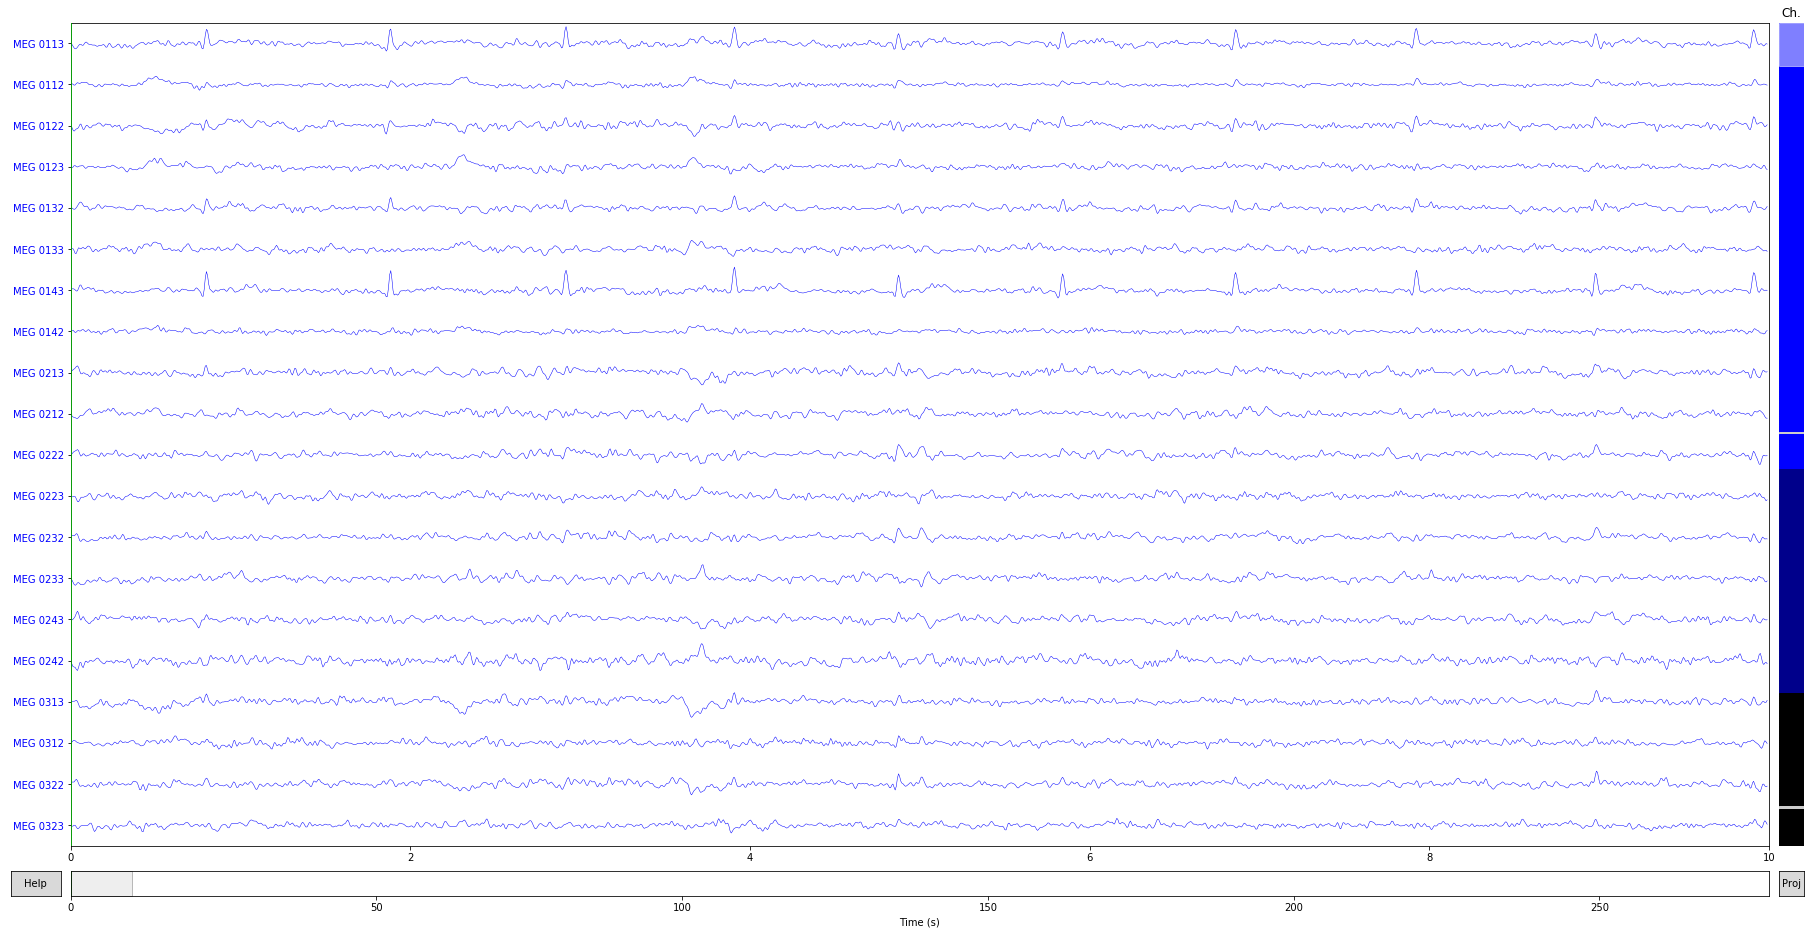

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 25 components
Fitting ICA took 3.3s.
Transforming to ICA space (25 components)
Zeroing out 1 ICA components


In [4]:
from mne.preprocessing import ICA

raw.plot();
ica = ICA(n_components=25, method='fastica', random_state=23).fit(raw)
ica.exclude = [1]
raw_clean = ica.apply(raw.copy())

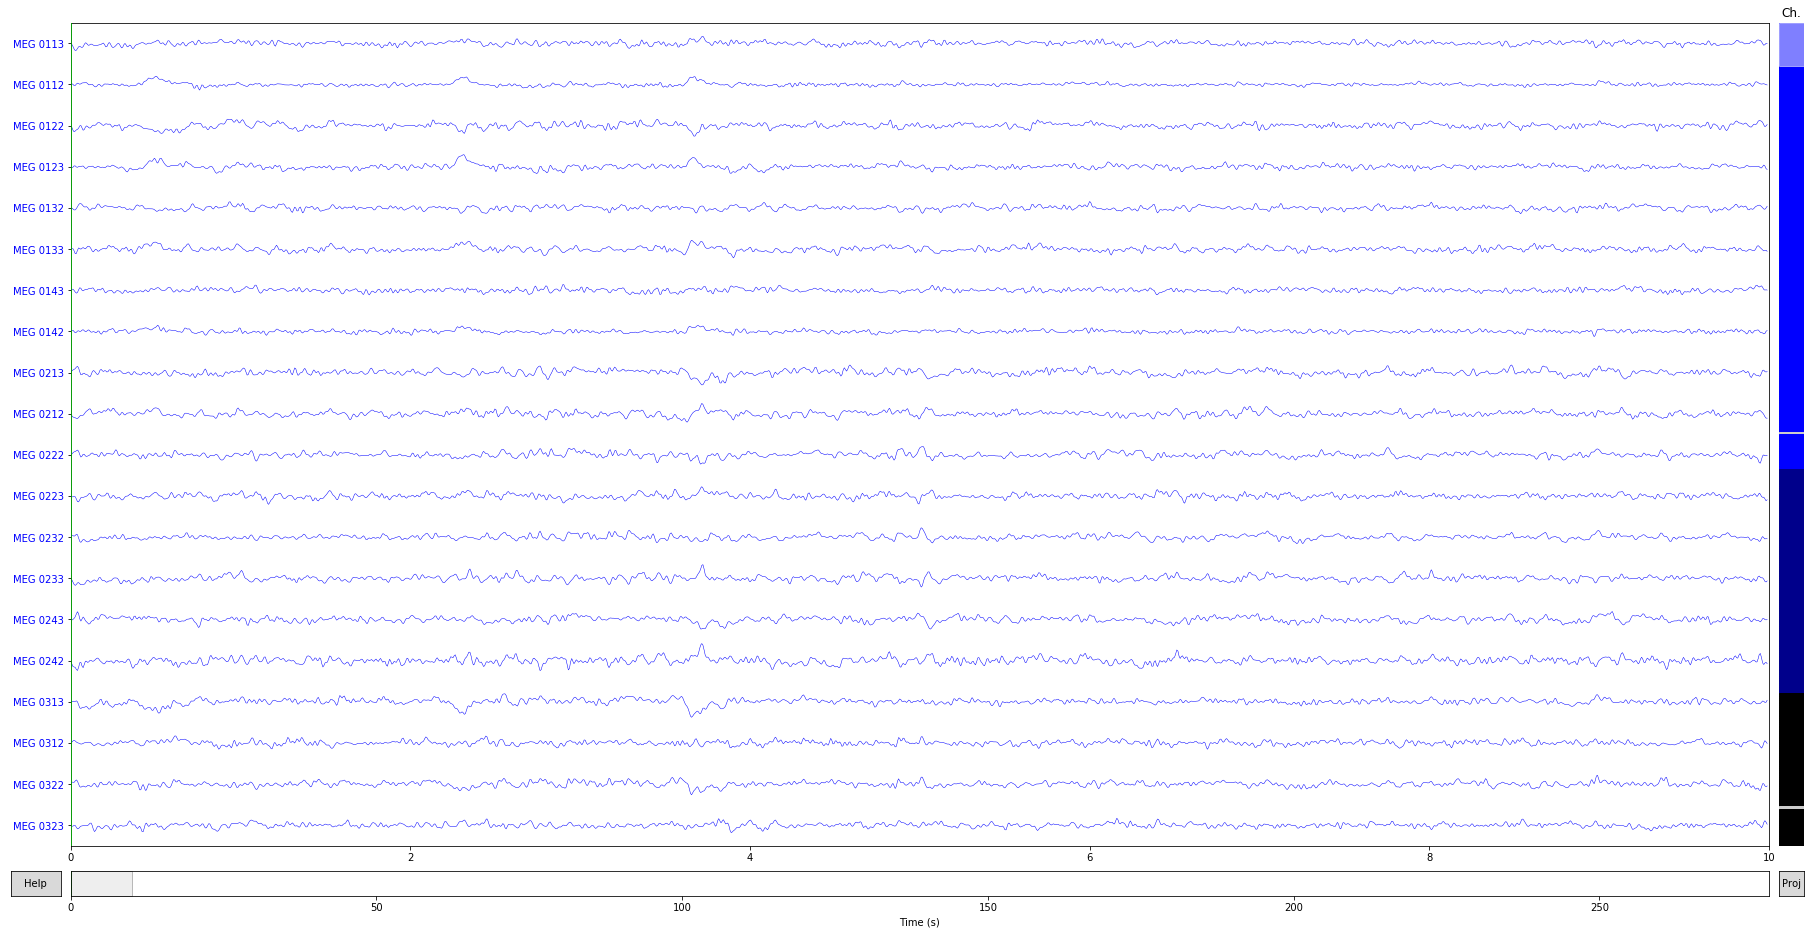

In [5]:
raw_clean.plot();

Fit ICA
-------

First, choose the ICA method. There are currently four possible choices:
`fastica`, `picard`, `infomax` and `extended-infomax`.

In [6]:
method = 'fastica'

# Choose other parameters
n_components = 25  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

ICA is a non-deterministic algorithm, but we want to have the same decomposition
and the same order of components

In [7]:
random_state = 23

Define the ICA object instance



In [8]:
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


We avoid fitting ICA on crazy environmental artifacts that would
dominate the variance and decomposition



In [9]:
reject = dict(mag=5e-12, grad=4000e-13)

picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [4242, 4343]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [5858, 5959]
Selection by number: 25 components
Fitting ICA took 1.0s.
<ICA  |  raw data decomposition, fit (fastica): 13635 samples, 25 components, channels used: "mag"; "grad">


Plot ICA components



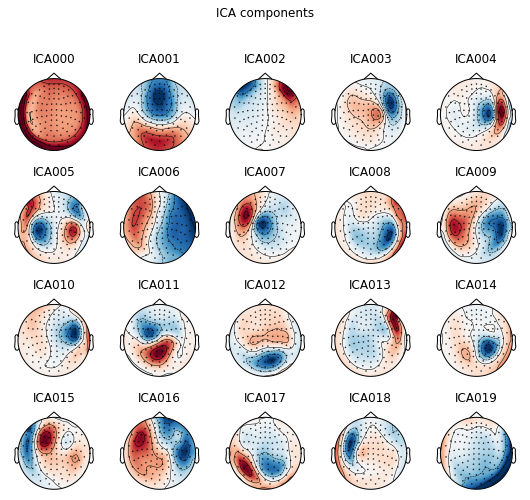

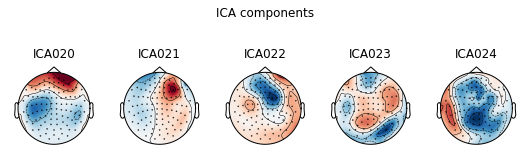

In [10]:
ica.plot_components();  # can you spot some potential bad guys?

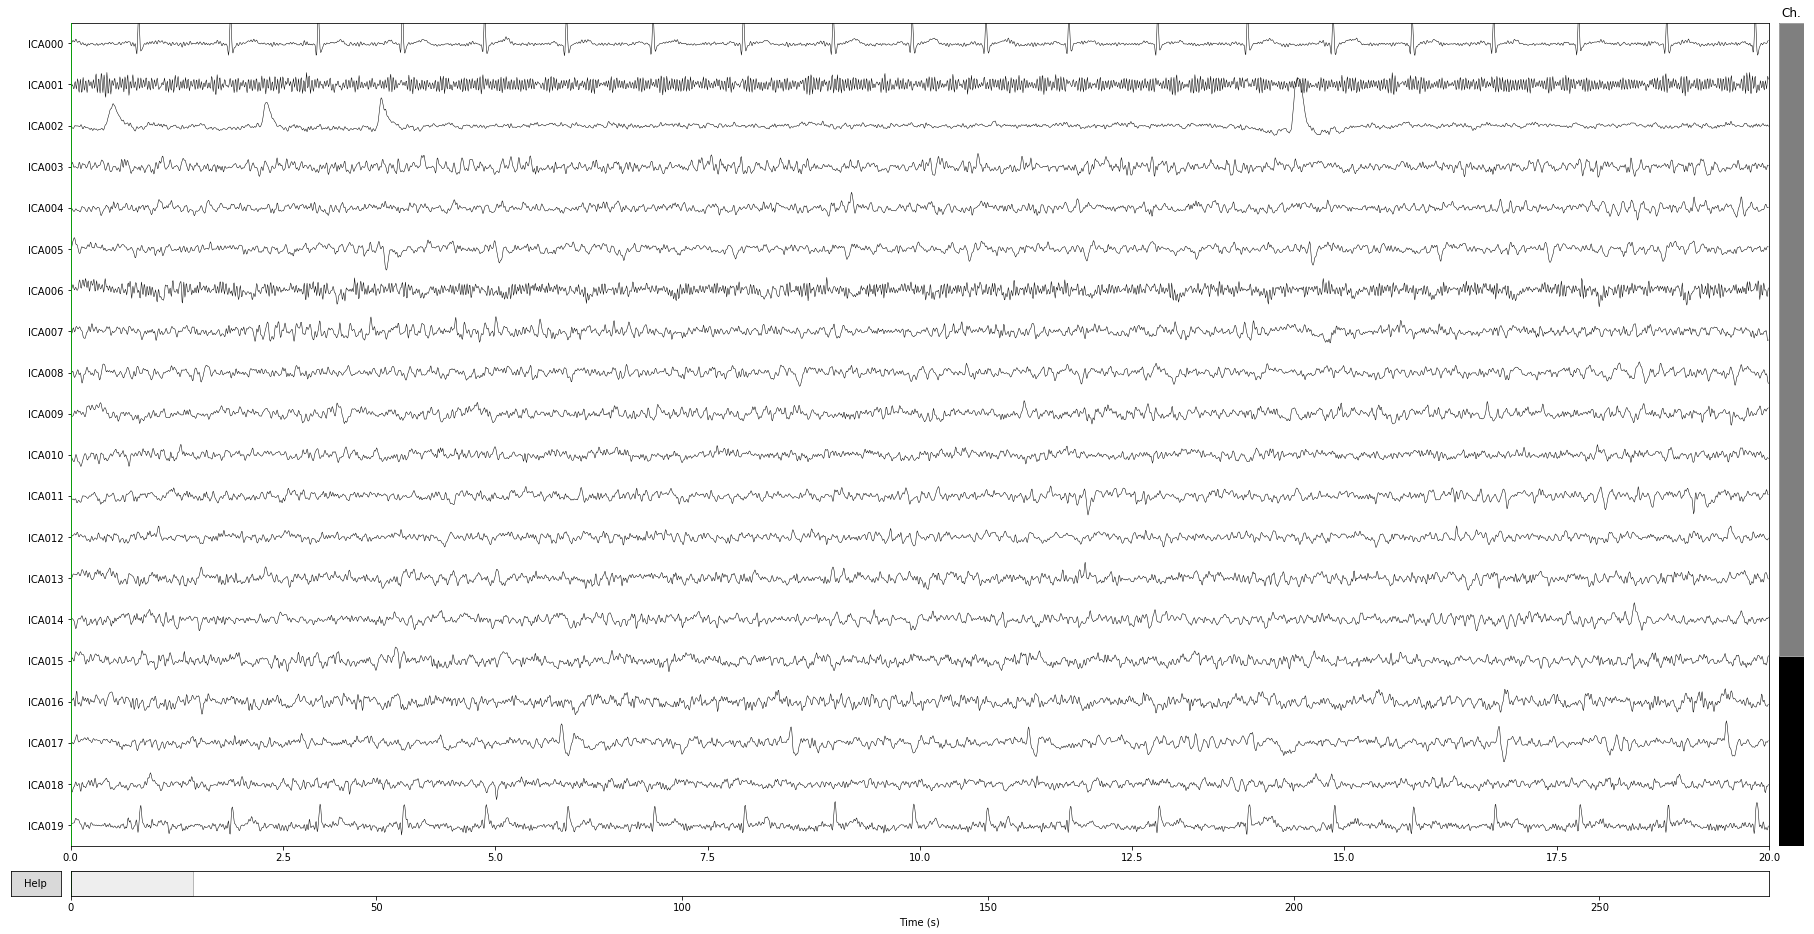

In [11]:
ica.plot_sources(raw);

Component properties
--------------------

Let's take a closer look at properties of first three independent components.



    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [12642, 12943]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [17458, 17759]
Creating RawArray with float64 data, n_channels=376, n_times=40936
Current compensation grade : 0
    Range : 0 ... 40935 =      0.000 ...   272.621 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows


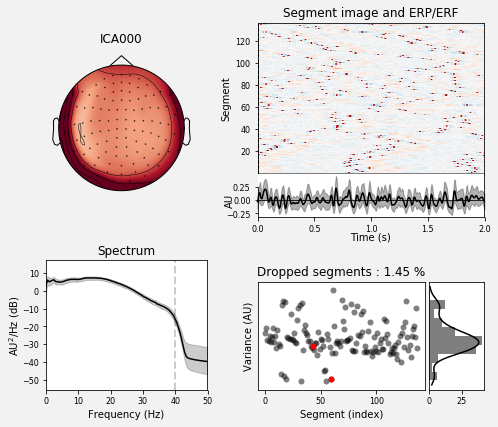

[<Figure size 504x432 with 6 Axes>]

In [12]:
# first, component 0:
ica.plot_properties(raw, picks=0)

Advanced artifact detection
---------------------------

Let's use a more efficient way to find artifacts



In [13]:
from mne.preprocessing import create_eog_epochs

eog_average = create_eog_epochs(raw, reject=dict(mag=5e-12, grad=4000e-13),
                                picks=picks_meg).average()

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 2048 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 46 events and 151 original time points ...
0 bad epochs dropped


EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 2048 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 4)
Loading data for 46 events and 151 original time points ...
0 bad epochs dropped


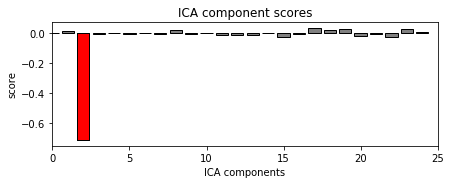

In [14]:
eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components

we can see that only one component is highly correlated and that this
component got detected by our correlation analysis (red).

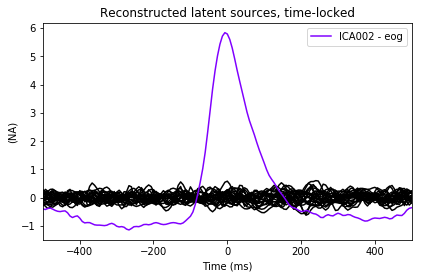

In [15]:
ica.plot_sources(eog_average, exclude=eog_inds);  # look at source time course

We can take a look at the properties of that component, now using the
data epoched with respect to EOG events.
We will also use a little bit of smoothing along the trials axis in the
epochs image:



    Using multitaper spectrum estimation with 7 DPSS windows


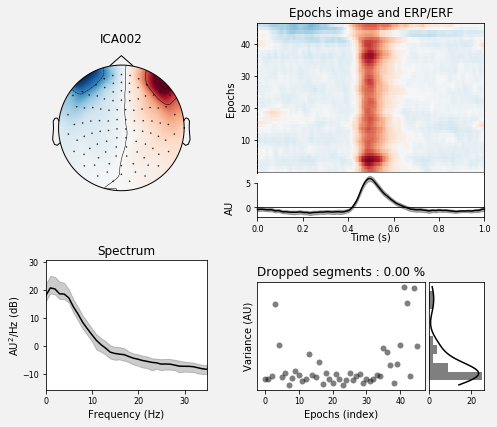

[<Figure size 504x432 with 6 Axes>]

In [16]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.})

Now let's see how we would modify our signals if we removed this component
from the data.


Transforming to ICA space (25 components)
Zeroing out 1 ICA components


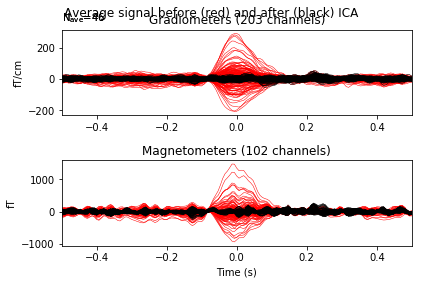

In [17]:
ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
# red -> before, black -> after. Yes! We remove quite a lot!

# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude.extend(eog_inds)

from now on the ICA will reject this component even if no exclude
parameter is passed, and this information will be stored to disk
on saving

In [18]:
# uncomment this for reading and writing
# ica.save('my-ica.fif')
# ica = read_ica('my-ica.fif')

Note that nothing is yet removed from the raw data. To remove the effects of
the rejected components, `mne.preprocessing.ICA.apply` must be called.
Here we apply it on the copy of the first ten seconds, so that the rest of
this tutorial still works as intended.

Transforming to ICA space (25 components)
Zeroing out 1 ICA components


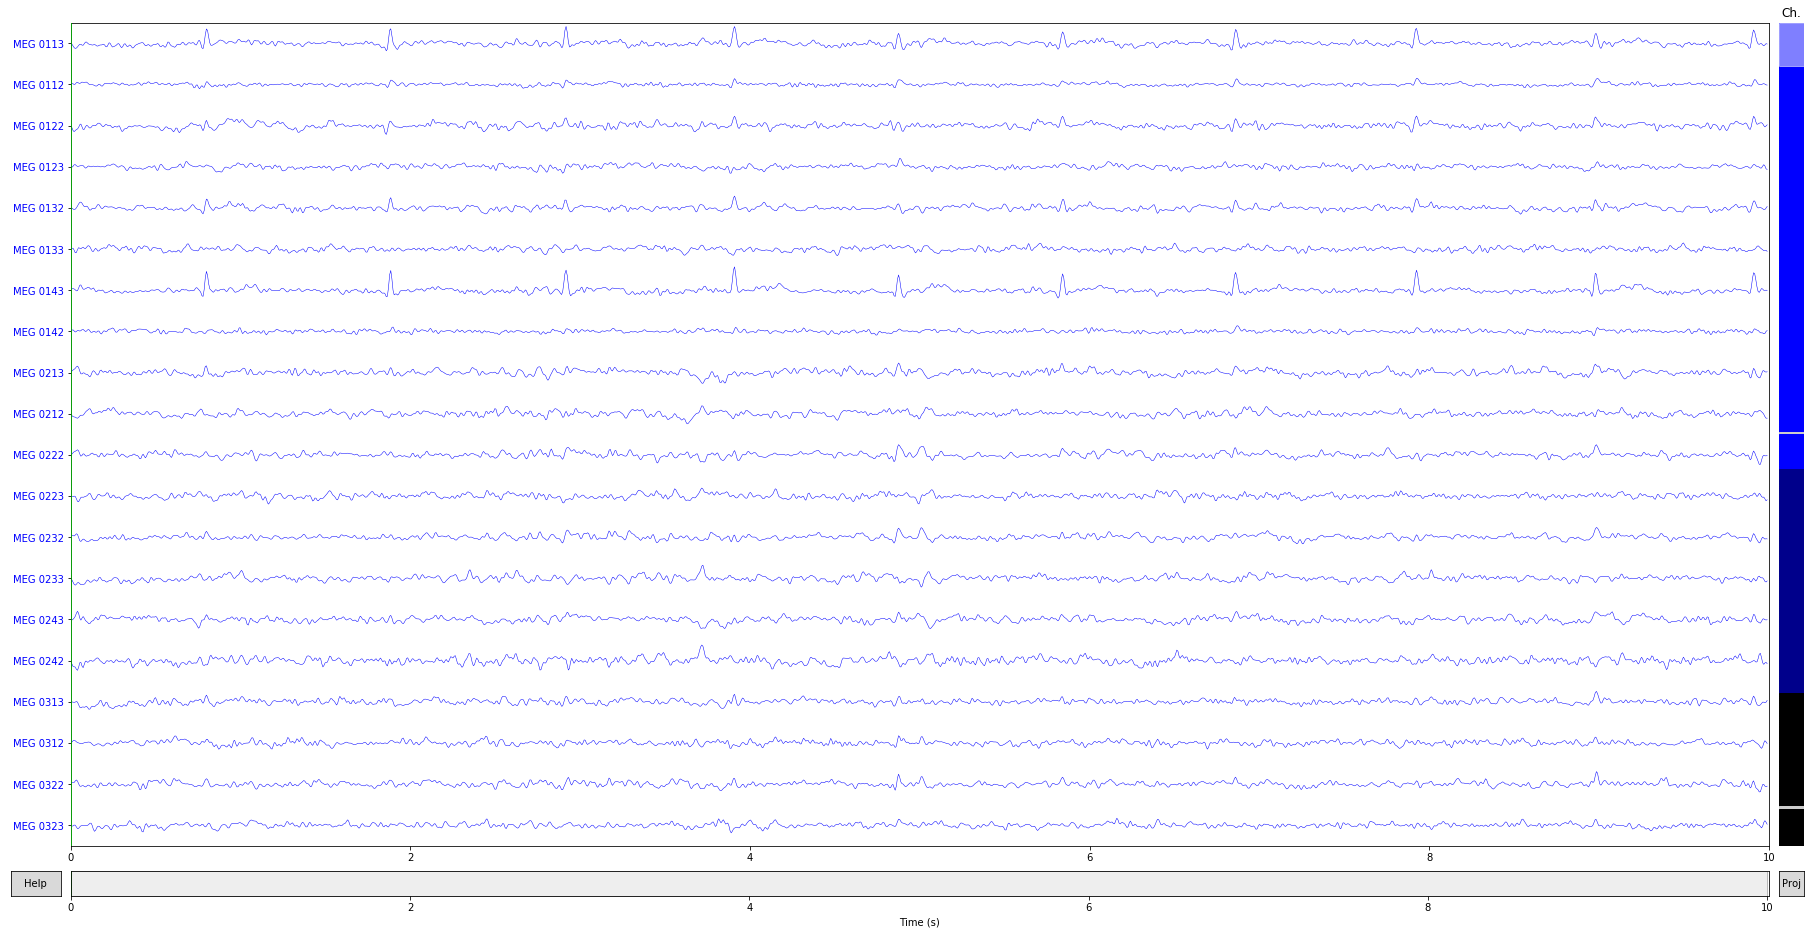

In [19]:
raw_copy = raw.copy().crop(0, 10)
ica.apply(raw_copy)
raw_copy.plot();  # check the result

Exercise
-------------

Find and remove ECG artifacts using ICA!



In [20]:
from mne.preprocessing import create_ecg_epochs